<a href="https://colab.research.google.com/github/SLCFLAB/Fintech2023-2/blob/main/ML_day2/2_2_Regression_Penalty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 어레이 데이터를 csv 파일로 저장하기
def save_data(fileName, arrayName, header=''):
    np.savetxt(fileName, arrayName, delimiter=',', header=header, comments='')

 ### Regression with regularization

모델의 학습 과정에 규제를 가하는 방식으로 과대 적합을 감소시킬 수 있다.
다항 회귀 모델의 경우 다항식의 차수를 감소시키는 방식으로 규제할 수 있다.

선형 회귀 모델의 규제는 학습되는 일반적으로 파라미터에 제한을 두는 방식으로 이루어진다.
* Ridge Regression
* Rasso Regression
* Elastic Net


### Ridge Regression

아래 코드는 연습을 위해 1차 함수를 이용하여 20개의 훈련 데이터를 생성한다.

* `X`: 훈련 세트, 크기는 20.
* `X_new`: 100개의 검증용 데이터.

In [2]:
np.random.seed(42)

m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5     # 1차 선형회귀 모델을 따로도록 함. 단, 잡음 추가됨.
X_new = np.linspace(0, 3, 100).reshape(100, 1)    # 0~3 구간에서 균등하게 100개의 검증 데이터 선택

#### 릿지 회귀의 비용 함수

$$
\begin{align*}
J(\boldsymbol{\theta}) & = \text{MSE}(\boldsymbol{\theta}) + \dfrac{\alpha}{2}\sum\limits_{i=1}^{n}{\theta_i}^2 \\
& = \text{MSE}(\boldsymbol{\theta}) + \dfrac{\alpha}{2}\left (\theta_1^2 + \cdots + \theta_n^2 \right )
\end{align*}
$$

#### `Ridge` 모델

In [3]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

* `solver=sag`: 경사하강법을 지원하는 다양한 옵티마이저 중에 하나임. 계속해서 보다 개선된 옵티마이저가 개발됨.

In [4]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

아래 코드는 다양한 `alpha` 값의 영향력를 그래프로 보여준다.
오른편 그래프는 10차 다항 회귀가 적용된 경우 3 개를 보여준다.
`alpha`를 크게 할 수록 예측값의 그래프가 직선에 가까워짐을 볼 수 있다.

그림 저장: ridge_regression_plot


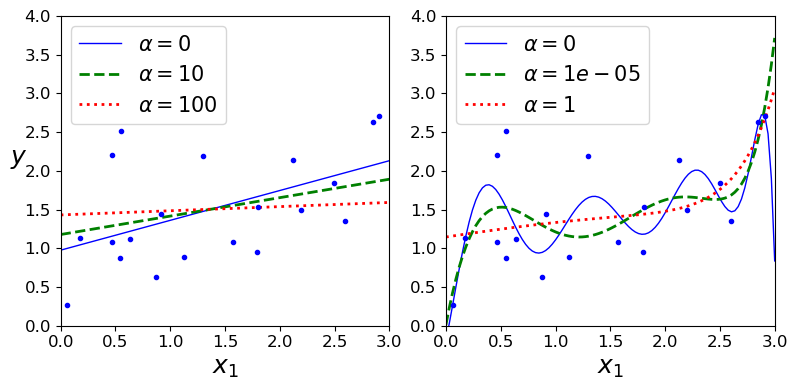

In [5]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),           # 표준화 축척 조정
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

### 4.5.2 라쏘 회귀 (p.187)

#### 라쏘 회귀의 비용 함수

$$
\begin{align*}
J(\boldsymbol{\theta}) & = \text{MSE}(\boldsymbol{\theta}) + \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| \\
& = \text{MSE}(\boldsymbol{\theta}) + \alpha \left (\, \left| \theta_1 \right| + \cdots + \left| \theta_n \right|\, \right )
\end{align*}
$$

#### `Lasso` 모델

In [6]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

그림 저장: lasso_regression_plot


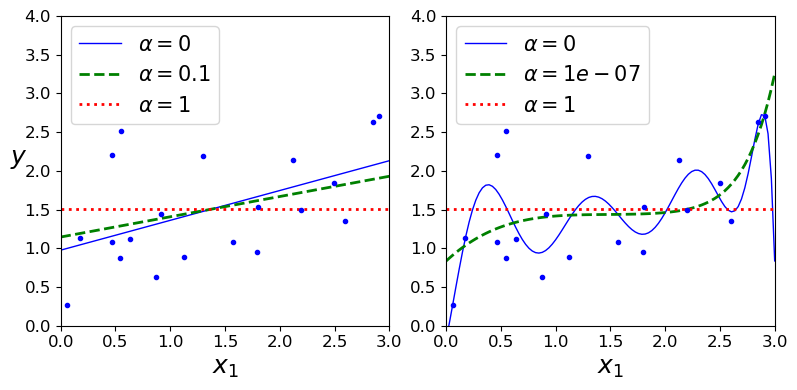

In [7]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

In [8]:
# 도표에 사용되는 좌표값 모음
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

### Logistic Regression

붓꽃(iris) 데이터셋을 이용하여 로지스틱 회귀를 이용한 분류에 활용되는 결정 경계를 설명한다.
아래 코드는 사이킷런에서 제공하는 붓꽃 데이터셋을 번치(Bunch) 자료형으로 불러온다.

__참고:__ `Bunch` 자료형은 기본적으로 `dict` 자료형과 동일하다.
차이점은 인덱싱을 속성(attribute)처럼 처리할 수 있다는 것 뿐이다.

In [9]:
from sklearn import datasets
iris = datasets.load_iris()

데이터셋에 사용된 키는 다음과 같다.

In [10]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

`'data'` 키에 해당하는 값은 (150, 4) 모양의 넘파이 어레이다.

- 150: 150개의 붓꽃 샘플
- 4: 네 개의 특성. 차례대로 꽃받침 길이, 꽃받침 너비, 꽃잎 길이, 꽃잎 너비.

아래 코드는 처음 5개의 샘플 데이터를 보여준다.

__참고:__ 원래 `iris['data'][:5]`로 값을 확인하지만 `Bunch` 자료형이기에 아래와 같이 클래스의
속성 형식으로 확인할 수도 있다. 인용부호를 사용하지 않음에 주의해야 한다.

In [11]:
iris.data[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

`'target'` 키는 150개 붓꽃에 대한 품종을 1차원 어레이로 담고 있다.

- 0: 세토사(Iris-Setosa)
- 1: 버시컬러(Iris-Versicolor)
- 2: 버지니카(Iris-Virginica)

언급된 순서대로 50개씩 세 품종의 타깃이 저장되어 있으며,
처음 5개의 샘플은 세토사 품종임을 아래처럼 확인할 수 있다.

In [12]:
iris.target[:5]

array([0, 0, 0, 0, 0])

50번 인덱스부터는 버시컬러 품종이다.

In [13]:
iris.target[50:55]

array([1, 1, 1, 1, 1])

100번 인덱스부터는 버지니카 품종이다.

In [14]:
iris.target[100:105]

array([2, 2, 2, 2, 2])

이런 정보가 `'DESCR'` 속성에 저장되어 있다.

In [15]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

#### 이진 분류: 로지스틱 회귀

__예제 1__

아래 코드는 이진 분류 설명을 위해 꽃잎 너비(petal width) 특성을 이용하여 버지니카 품종 여부를 판정하는 데에
사용되는 데이터셋을 지정한다.

In [16]:
X = iris["data"][:, 3:]                   # 1개의 특성(꽃잎 너비)만 사용
y = (iris["target"] == 2).astype(np.int64)  # 버지니카(Virginica) 품종일 때 1(양성)

이제 사이킷런의 LogisticRegression 모델을 훈련시킨다.

**참고**: 사이킷런 0.22 버전의 기본값인 `solver="lbfgs"`로 지정

In [17]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

In [18]:
log_reg.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [19]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y, log_reg.predict(X))

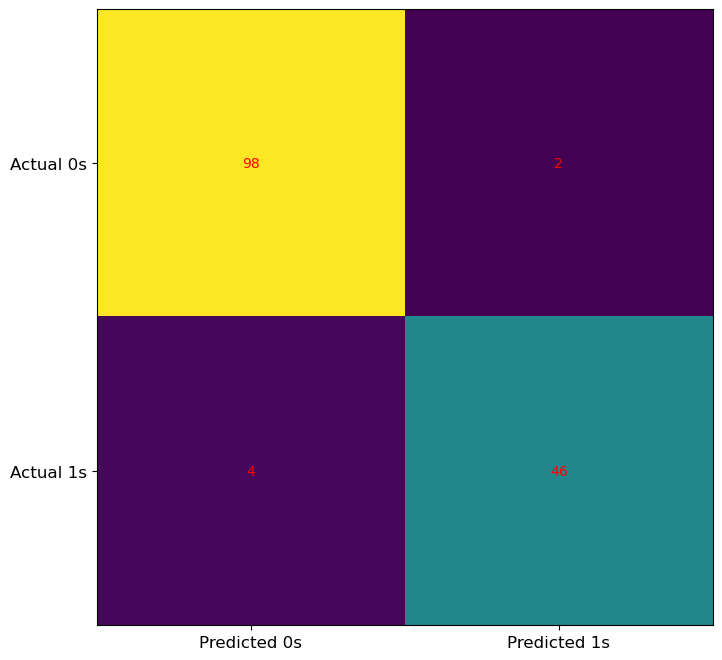

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

1000개의 샘플을 새로 생성하여 훈련된 로지스틱 회귀 모델의 예측 결과를 도표로 확인하면 다음과 같다.

* `X_new`: 0~3구간을 1000등분한 값 1000개. 즉, 꽃잎의 너비를 0에서 3사이에서 1000개 선택.
* `y_proba`: 각 샘플에 대한 양성 확률
- x 축: 꽃잎 너비 크기
- 초록 실선: 버지니카(양성) 확률
- 파랑 점선: 버지니카가 아닌(음성) 확률

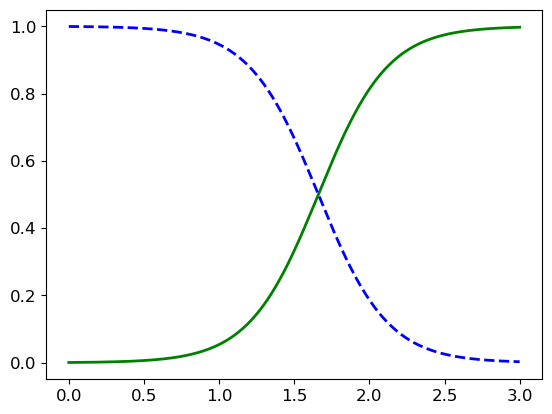

In [22]:
X_new = np.linspace(0, 3, 1000).reshape(1000, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

&#x270b; 아래 코드는 보다 많은 정보를 도표와 함께 전달한다.

- y=1.0를 지난 수평선
- x=1.66 근처의 결정 경계(decision boundary): 검은 수직 점선
- 초록 삼각형: 버지니카 품종
- 파랑 사각형: 버지니카 아닌 품종

그림 저장: logistic_regression_plot


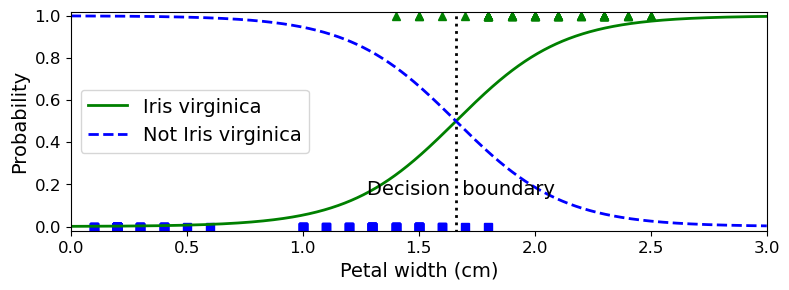

In [23]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

양성 확률이 0.5가 되는 꽃잎 너비의 길이, 즉 결정 경계는 1.66이다.

In [24]:
decision_boundary

array([1.66066066])

실제로 1.66보다 크면 양성, 작으면 음성으로 판정한다.

In [25]:
log_reg.predict([[1.7], [1.5]])

array([1, 0], dtype=int64)

__예제 2__

아래 코드는 이진 분류 설명을 위해 꽃잎 길이와 너비 두 개의 특성을 이용하여
버지니카 품종 여부를 판정하는 모델을 훈련한다.

In [26]:
X = iris["data"][:, (2, 3)]                  # 꽃잎 길이와 너비
y = (iris["target"] == 2).astype(np.int64)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=10000000000, random_state=42)

훈련 결과를 도표로 그리면 다음과 같다.

- 검은 실선: 결정 경계
- 다른 직선들: 버지니카(양성) 추정 확률별 결정 경계를 보여줌.

그림 저장: logistic_regression_contour_plot


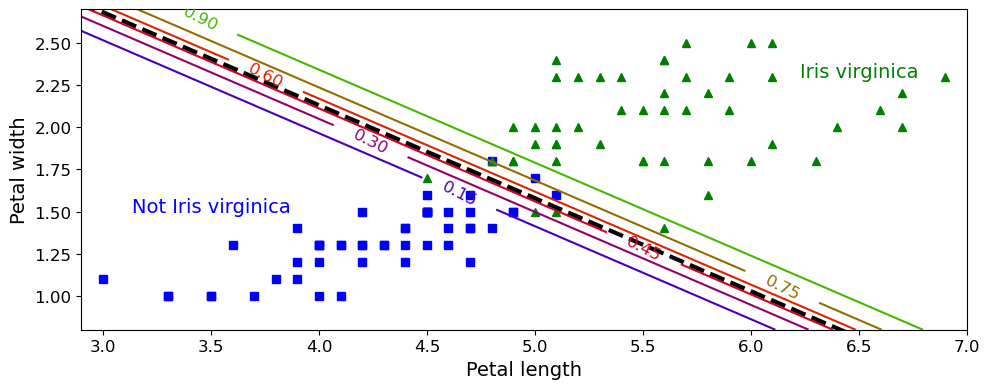

In [27]:
x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()